In [2]:
# считываем данные с файлов
import os
import re

neg = "review_polarity/txt_sentoken/neg"
pos = "review_polarity/txt_sentoken/pos"

def convert_text(s):
    # Removes all characters from string except letters and digits and convert letters to lowercase
    return re.sub("[^a-zA-Z0-9]", " ", s.lower())

def read_texts(dir_path):
    # Reads all files from directory
    if dir_path[-1] != os.path.sep:
        dir_path = dir_path + os.path.sep
    txt_list = []
    for file in os.listdir(dir_path):
        file = dir_path + file
        fin = open(file, 'r', encoding='UTF-8')
        txt = " ".join(fin.readlines())
        txt = convert_text(txt)
        txt_list.append(txt)
    return txt_list

In [4]:
# создаем матрицу и настраиваем ее по-новому (n-gram = 2)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd

texts = read_texts(neg) + read_texts(pos)

count = CountVectorizer(token_pattern=r"\b\w+\b", ngram_range=(2, 2), lowercase=True, max_features=20000, min_df=2)
result = count.fit_transform(texts).toarray()
df = pd.DataFrame(data=result, columns=count.get_feature_names())

In [5]:
import numpy as np
zeros = np.zeros((1000,), dtype=np.int)
ones = np.ones((1000,), dtype=np.int)
vec = np.hstack((zeros,ones))

In [6]:
# разбиваем выборку на тренировочную и тестовую часть
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(result, vec, train_size=0.7, random_state=12345)

In [7]:
# создаем функцию, которая будет все считать
from sklearn import metrics
from datetime import datetime
from sklearn.base import clone

def model_func(model, X_train, y_train, X_test, y_test):
    startTime = datetime.now()

    temp_model = clone(model)
    temp_model.fit(X_train, y_train)

    expected = y_test
    predicted = temp_model.predict(X_test)
    accuracy = metrics.accuracy_score(expected, predicted)
    print('Доля правильных ответов:', accuracy)
    print('Затраченное время:', datetime.now() - startTime)

In [8]:
# обучаем модель k-ближайших соседей (пока без Tfidf)
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

model_func(knn, X_train, y_train, X_test, y_test)

Доля правильных ответов: 0.581666666667
Затраченное время: 0:00:32.192292


In [9]:
# обучаем логистическую регрессию (пока без Tfidf)
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1,solver="lbfgs", random_state=12345)

model_func(lr, X_train, y_train, X_test, y_test)

Доля правильных ответов: 0.783333333333
Затраченное время: 0:00:03.902235


In [10]:
# обучаем мультиномиальный наивный Байес (пока без Tfidf)
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

model_func(mnb, X_train, y_train, X_test, y_test)

Доля правильных ответов: 0.818333333333
Затраченное время: 0:00:00.332622


In [20]:
# Tfidf

tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [21]:
# обучаем модель k-ближайших соседей
knn = KNeighborsClassifier()

model_func(knn, X_train_tfidf, y_train, X_test_tfidf, y_test)

Доля правильных ответов: 0.658333333333
Затраченное время: 0:00:00.202547


In [22]:
# обучаем логистическую регрессию
lr = LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1,solver="lbfgs", random_state=12345)

model_func(lr, X_train_tfidf, y_train, X_test_tfidf, y_test)

Доля правильных ответов: 0.81
Затраченное время: 0:00:00.094639


In [23]:
# обучаем мультиномиальный наивный Байес
mnb = MultinomialNB()

model_func(mnb, X_train_tfidf, y_train, X_test_tfidf, y_test)

Доля правильных ответов: 0.798333333333
Затраченное время: 0:00:00.013064


### Кажется, я делаю что-то не то...

ммм... наверное потому, что повторять нужно на k-folds и выбирать параметры...

In [24]:
ns = np.arange(1, 150, 20) # количество соседей
cs = np.logspace(-2, 10, 8, base=10) # параметр регуляризации
alphas = np.logspace(-4, 1, 8, base=10) # сглаживающий параметр

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline

In [32]:
from sklearn.cross_validation import KFold
from sklearn.base import clone

In [33]:
def model_CV(model, X, y):
    as_test = 0
    as_train = 0
    
    startTime = datetime.now()

    kf = KFold(X.shape[0], n_folds=4, random_state = 12345)
    
    y_pred = np.zeros(y.shape[0])
    for train, test in kf:
        temp_model = clone(model)
        
        X_train = X[train]
        X_test = X[test]
        
        y_train = y[train]
        y_test = y[test]
    
        tfidf = TfidfTransformer()
        X_train_tfidf = tfidf.fit_transform(X_train)
        X_test_tfidf = tfidf.transform(X_test)
        
        # берем блок для обучения
        temp_model.fit(X_train_tfidf, y_train)
        
        # считаем качество на обучении
        y_pred[train] = temp_model.predict(X_train)
        as_test = as_test + metrics.accuracy_score(y_train, y_pred[train])
        
        # считаем качество на валидации
        y_pred[test] = temp_model.predict(X_test_tfidf)
        as_train = as_train + metrics.accuracy_score(y_test, y_pred[test])
    
    mean_test = as_test / 4
    mean_train = as_train / 4
    
    print('Качество на обучении: ', mean_test)
    print('Качество на валидации: ', mean_train)    
    print('Затраченное время:', datetime.now() - startTime)
    return mean_train

In [34]:
def plot(x, y):    
    plt.plot(x, y)
    plt.xlabel("Значение гиперпараметра")
    plt.ylabel("Качество модели")
    return plt

In [35]:
X = result
y = vec

In [36]:
# меняем параметры моделей

# kNN
qualities_knn = []
print('kNN')
for n in ns:
    print('n:', n)
    knn = KNeighborsClassifier(n_neighbors=n)    
    model = knn
    quality = model_CV(model, X, y)
    qualities_knn.append(quality)
    print(qualities_knn)
    print('--')

kNN
n: 1
Качество на обучении:  1.0
Качество на валидации:  0.526
Затраченное время: 0:00:10.565814
[0.52600000000000002]
--
n: 21
Качество на обучении:  0.723666666667
Качество на валидации:  0.303
Затраченное время: 0:00:10.016979
[0.52600000000000002, 0.30299999999999999]
--
n: 41
Качество на обучении:  0.719666666667
Качество на валидации:  0.2135
Затраченное время: 0:00:09.887812
[0.52600000000000002, 0.30299999999999999, 0.21350000000000002]
--
n: 61
Качество на обучении:  0.716
Качество на валидации:  0.166
Затраченное время: 0:00:10.425026
[0.52600000000000002, 0.30299999999999999, 0.21350000000000002, 0.16600000000000001]
--
n: 81
Качество на обучении:  0.707166666667
Качество на валидации:  0.131
Затраченное время: 0:00:10.495449
[0.52600000000000002, 0.30299999999999999, 0.21350000000000002, 0.16600000000000001, 0.13100000000000001]
--
n: 101
Качество на обучении:  0.7015
Качество на валидации:  0.098
Затраченное время: 0:00:10.007277
[0.52600000000000002, 0.3029999999999999

Что-то ужасное качество на валидации...
Но возможно это и плюс. Изначально задание заключается в отнесении объекта (текста) к одному из 2 классов (позитивный или негативный). Если мы в 7% случаев называем правильный класс, то в 93% - неправильный. Однако такой алгоритм можно считать хорошим, потому что если мы мысленно (или не мысленно) будем менять предсказанный класс на противоположный, то в 93% случаев мы угадаем истинный класс.
#####
Стоит заметить, что качество на обучении достаточно хорошее. Это свидетельствует о переобучении модели.

График для kNN


<module 'matplotlib.pyplot' from '/Users/anastasiarodygina/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

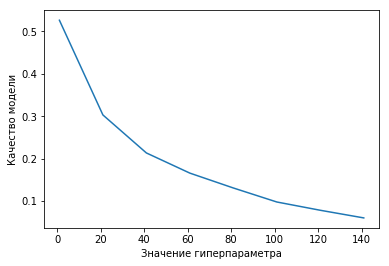

In [38]:
# График для kNN
print('График для kNN')
plot(ns, qualities_knn)

График очень похож на тот, что был при n-gram = 1, мы снова выбираем 1 соседа в качестве гиперпараметра. Но это возможно изменилось бы, если бы мы воплотили в жизнь идею с изменением класса на противоположный.

In [39]:
# kNN
# Настроим модель с использованием выбранного гиперпараметра
knn_itog = KNeighborsClassifier(n_neighbors=1)

In [40]:
# lr
print('Logistic Regression')
qualities_lr = []
for c in cs:
    print('c:', c)
    lr = LogisticRegression(C=c, solver="lbfgs", random_state=12345)
    model = lr
    quality = model_CV(model, X, y) # вот это почему-то не работает, хотя в функции указан return
    qualities_lr.append(quality)
    print(qualities_lr)
    print('--')

Logistic Regression
c: 0.01
Качество на обучении:  0.695
Качество на валидации:  0.0
Затраченное время: 0:00:05.302067
[0.0]
--
c: 0.517947467923
Качество на обучении:  0.810166666667
Качество на валидации:  0.01
Затраченное время: 0:00:05.301413
[0.0, 0.01]
--
c: 26.8269579528
Качество на обучении:  0.923666666667
Качество на валидации:  0.5425
Затраченное время: 0:00:06.339060
[0.0, 0.01, 0.54249999999999998]
--
c: 1389.49549437
Качество на обучении:  0.9445
Качество на валидации:  0.5975
Затраченное время: 0:00:06.800285
[0.0, 0.01, 0.54249999999999998, 0.59749999999999992]
--
c: 71968.5673001
Качество на обучении:  0.949166666667
Качество на валидации:  0.611
Затраченное время: 0:00:06.648765
[0.0, 0.01, 0.54249999999999998, 0.59749999999999992, 0.61099999999999999]
--
c: 3727593.72031
Качество на обучении:  0.915666666667
Качество на валидации:  0.6535
Затраченное время: 0:00:05.937759
[0.0, 0.01, 0.54249999999999998, 0.59749999999999992, 0.61099999999999999, 0.65349999999999997]


График для логистической регрессии


<module 'matplotlib.pyplot' from '/Users/anastasiarodygina/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

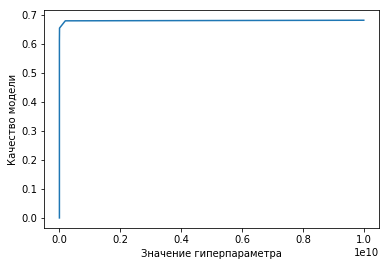

In [41]:
# График для логистической регрессии
print('График для логистической регрессии')
plot(cs, qualities_lr)

Ну, почти монетка. Чуть-чуть лучше. Лучший гиперпараметр: 10000000000.0

In [45]:
# lr
# Настроим модель с использованием выбранного гиперпараметра
lr_itog = LogisticRegression(C=10000000000.0)

In [42]:
# mnb
print('Multinomial NB')
qualities_mnb = []
for alpha in alphas:
    print('alpha:', alpha)
    mnb = MultinomialNB(alpha=alpha)
    model = mnb
    quality = model_CV(model, X, y)
    qualities_mnb.append(quality)
    print(qualities_mnb)
    print('--')

Multinomial NB
alpha: 0.0001
Качество на обучении:  0.9975
Качество на валидации:  0.3215
Затраченное время: 0:00:05.198906
[0.32150000000000001]
--
alpha: 0.000517947467923
Качество на обучении:  0.997
Качество на валидации:  0.3525
Затраченное время: 0:00:05.087404
[0.32150000000000001, 0.35250000000000004]
--
alpha: 0.00268269579528
Качество на обучении:  0.9965
Качество на валидации:  0.4
Затраченное время: 0:00:05.025780
[0.32150000000000001, 0.35250000000000004, 0.39999999999999997]
--
alpha: 0.0138949549437
Качество на обучении:  0.995833333333
Качество на валидации:  0.477
Затраченное время: 0:00:04.996039
[0.32150000000000001, 0.35250000000000004, 0.39999999999999997, 0.47699999999999998]
--
alpha: 0.0719685673001
Качество на обучении:  0.992166666667
Качество на валидации:  0.5365
Затраченное время: 0:00:04.676390
[0.32150000000000001, 0.35250000000000004, 0.39999999999999997, 0.47699999999999998, 0.53649999999999998]
--
alpha: 0.372759372031
Качество на обучении:  0.88316666

График для мультиномиального наивного байеса


<module 'matplotlib.pyplot' from '/Users/anastasiarodygina/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

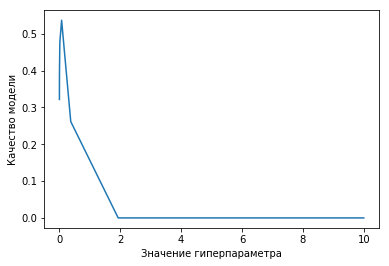

In [43]:
# График для мультиномиального наивного байеса
print('График для мультиномиального наивного байеса')
plot(alphas, qualities_mnb)

Как и в прошлый раз есть четко выраженный пик. Выбираем альфу, равную 0.0719685673001

In [46]:
# Настроим модель с использованием выбранного гиперпараметра
mnb_itog = MultinomialNB(alpha=0.0138949549437)

In [47]:
# kNN
model_func(knn_itog, X_train_tfidf, y_train, X_test, y_test)

Доля правильных ответов: 0.606666666667
Затраченное время: 0:00:00.609310


In [48]:
# lr
model_func(lr_itog, X_train_tfidf, y_train, X_test, y_test)

Доля правильных ответов: 0.695
Затраченное время: 0:00:00.285827


In [49]:
# mnb
model_func(mnb_itog, X_train_tfidf, y_train, X_test, y_test)

Доля правильных ответов: 0.821666666667
Затраченное время: 0:00:00.064968


# Пункт 5
Выведите итоговые данные по всем методам для лучших моделей (метод, n-gram, значение параметра модели, время обучения, время предсказания, доля правильных классификаций)

-- Какие модели считать лучшими? В задании было сказано использовать долю правильных ответов, а это, как известно, далеко не самый лучший способ оценки модели. Рассмотрим ситуации, когда качество модели было выше 0,8.

### n-gram = 1

1. Предварительно обработанная CountVectorizer-ом матрица, разбитая на тренировочную и тестовую выборки используется при обучении логистической регрессии. Параметры: (penalty="l2", fit_intercept=True, max_iter=100, C=1, solver="lbfgs", random_state=12345). Время обучения и предсказания: 0:00:08.993048. Доля правильных классификаций: 0.806666666667

2. Мультиномиальный наивный Байес. CountVectorizer, разбиение на тренировочную и тестовую выборки, параметры по умолчанию (alpha = 1). Время обучения и предсказания: 0:00:00.713125. Доля правильных классификаций: 0.803333333333

Я могу объяснить это тем, что метод tfidf не подходит для данной конкретной задачи. CountVectorizer справляется гораздо лучше.

### n-gram = 2

1. Мультиномиальный наивный Байес. CountVectorizer, разбиение на тренировочную и тестовую выборки, параметры по умолчанию (alpha = 1). Время обучения и предсказания: 0:00:00.332622. Доля правильных классификаций: 0.818333333333

2. Логистическая регрессия. CountVectorizer, разбиение на тренировочную и тестовую выборки. Параметры: (penalty="l2", fit_intercept=True, max_iter=100, C=1, solver="lbfgs", random_state=12345). Время обучения и предсказания: 0:00:00.094639. Доля правильных классификаций: 0.81

3. Мультиномиальный наивный Байес. CountVectorizer, TfidfTransformer, k-Folds, alpha = 0.0138949549437. Время обучения и предсказания: 0:00:00.064968. Доля правильных классификаций:0.821666666667

# Пункт 6
Сделайте выводы по полученным результатам: какой метод показал наилучшее качество на обучении? на валидации? на тестовой выборке? Если это разные классификаторы, подумайте, почему так происходит. Если один и тот же, в чем его преимущества перед остальными? велика ли разница между качеством на обучении и на валидации? на валидации и контроле? Почему так происходит? что означает n-gram=2? Улучшилось ли качество при переходе от n-gram=1 к n-gram=2? Предложите свои идеи, почему. есть ли связь между качеством классификации и временем обучения/предсказания? какой классификатор обучается медленнее всего? медленнее всего делает предсказания? В чем причина?

--

На обучении лучшее качество показал мультиномиальный наивный байес (см. первый ноутбук) (при n-gram = 1 и n-gram = 2), а также логистическая регрессия (при n-gram = 2). Регрессия наверное все-таки чуть лучше.

На валидации тоже регрессия. В обоих из рассмотренных случаев.

На тестовой выборке тоже логистическая регрессия. Но байес уступает ей совсем чуть-чуть.

Очевидно, регрессия побеждает. Я думаю, причина кроется в том, что мы изначально использовали один из ее параметров не по умолчанию, а в двух других алгоритмах - дефолтные.

Разница между качеством на обучении и валидации велика. Это видно невооруженным глазом.

n-gram = 2 - это аргумент  vectorizer-а  ngram_range, принимающий значение (2,2)

Качество улучшилось при переходе от n-gram=1 к n-gram=2.

Я считаю, что связи между качеством классификации и временем обучения/предсказания нет. Скорость зависит от мощности компьютера, который производит вычисления.

Медленнее всего обучается kNN. Причина - много времени уходит на рассчет расстояний до всех соседей.